## 代辦事項
定義有人布局  ： 殖利率公布前之漲幅 or 每日低不過前低  
Ex：
聯陽  過去20天有10%左右漲幅
華碩  過去30天低點至公布日有6%左右漲幅，但應該有符合低點有人護
興富發  過去30天有10%左右漲幅
沛波  過去30天有10%左右漲幅，如果開低8%就不空，可能紅K，
公布近五天，每日收盤價高於最低點1%

殖利率可以跟同業的比
另外找出分點的布局重不重




將周末公布的納入

# 導入模塊以及自定義模塊並修正路徑

In [4]:
# 導入模塊
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import sqlite3
import sys
import datetime
import math
# import shioaji as sj
sys.path.append('..')
# silence warnings
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
# sns.set(font='Taipei Sans TC Beta')

# 自定義模塊
import util.dayTrade as dt
%reload_ext autoreload
%autoreload 2
import importlib
importlib.reload(dt)

<module 'util.dayTrade' from 'c:\\Users\\a124a\\OneDrive\\桌面\\TEJ\\camel\\Project\\util\\dayTrade\\__init__.py'>

In [2]:
pd.set_option('display.max_columns', 40)
# pd.set_option('display.max_rows', 150)

# 要導入的資料

In [3]:
df = dt.getFullData(startDate='2017-01-01', columns=['成交值(千元)', '流通在外股數(千股)'])

# 處理未導入條件

## 價量

In [4]:
try:
    df['K棒收點'] = (df['收盤價(元)'] - df['最低價(元)']) / (df['最高價(元)'] - df['最低價(元)'])
    df['開盤價(元)'] = df['開盤價(元)'][df['開盤價(元)'] != 'N.A.']
    df['本益比-TEJ'] = df['本益比-TEJ'][df['本益比-TEJ'] != 'N.A.']
    df['開盤價(元)'] = pd.to_numeric(df['開盤價(元)'])
    df['本益比-TEJ'] = pd.to_numeric(df['本益比-TEJ'])
    df['年月日'] = pd.to_datetime(df['年月日'] )
    df['當沖收益'] = ((df['收盤價(元)'] - df['開盤價(元)']) / df['收盤價(元)'])
    df = df.set_index(['年月日', '證券代碼'])
    df['漲跌幅'] = df.groupby('證券代碼')['收盤價(元)'].pct_change() * 100
    df['開收比'] = (df['收盤價(元)'] - df['開盤價(元)']) / df['開盤價(元)'] * 100
    df['成交值等級'] = df.groupby('年月日')['成交值(千元)'].rank(ascending=False)
    df['股本(億)'] = df['流通在外股數(千股)']*1000*10 / 100000000
except Exception as e :
    print(e)

In [5]:
df_dtable = dt.getDTAble()
try:
    df_dtable = df_dtable.drop(columns='index')
    df_dtable['年月日'] = pd.to_datetime(df_dtable['年月日'])
    df_dtable = df_dtable.reset_index()
    df_dtable = df_dtable[df_dtable['證券代碼'].notnull()]
    df_dtable = df_dtable.set_index(['年月日', '證券代碼'])
    df_dtable = df_dtable.loc[df_dtable.index.intersection(df.index)]
    df_dtable = df_dtable.sort_index(level='年月日')
    # df = pd.concat([df, df_dtable], axis=1)
    df = pd.merge(df, df_dtable, on=['年月日', '證券代碼'], how='left')
    df['當沖成交比重%'] = df['當沖成交股數(千股)'] / df['成交量(千股)'] * 100
    df['扣除當沖成交量'] = df['成交量(千股)'] - df['當沖成交股數(千股)'] 
    df['星期'] = df.index.get_level_values(0).dayofweek + 1
except Exception as e:
    print(e)

In [6]:
df.iloc[:, 0:4] = df.iloc[:, 0:4].applymap(dt.dRound)

df_originalColumns = []
for column in df.columns:
    if '昨天' in column or '前天' in column or '前三天' in column:
        continue
    else:
        df_originalColumns.append(column)

for column in df_originalColumns:
    df_group = df.groupby('證券代碼')
    df['昨天' + column] = df_group[column].shift(1)
    df['前天' + column] = df_group[column].shift(2)
    df['前三天' + column] = df_group[column].shift(3)
df['明天開盤價(元)'] = df.groupby('證券代碼')['開盤價(元)'].shift(-1)
df['明天漲跌停'] = df.groupby('證券代碼')['漲跌停'].shift(-1)
df['明天收盤價(元)'] = df.groupby('證券代碼')['收盤價(元)'].shift(-1)

## 導入殖利率資料庫

In [7]:
db_name = dt.getDataPath('dailyChips.db')
conn = sqlite3.connect(db_name)
df_returnCall = pd.read_sql(con=conn, sql="SELECT * FROM 'resultsCall'")

df_returnCall['股利公告日'] = pd.to_datetime(df_returnCall['Q4_股息決議董事會'], renameformat='%Y%m%d')
df_returnCall['年月日'] = df_returnCall['股利公告日']
df_returnCall['是否為股利公布日'] = 1
df_returnCall['星期幾公布'] = df_returnCall['股利公告日'].dt.weekday

df_returnCall = df_returnCall.set_index(['年月日', '證券代碼'])
# df_returnCall

In [8]:

df_midStop2 = pd.DataFrame(index=df.index.union(df_returnCall.index))
df_midStop2 = pd.merge(df_midStop2, df_returnCall[['是否為股利公布日', '累計_現金股利(元)', '股利公告日', '星期幾公布']], on=['年月日', "證券代碼"], how='left')
# df_midStop2

In [9]:
df_midStop2['累計_現金股利(元)'] = np.where(df_midStop2.groupby('證券代碼')['星期幾公布'].shift(2) == 6, df_midStop2.groupby('證券代碼')['累計_現金股利(元)'].shift(2), df_midStop2['累計_現金股利(元)'])
df_midStop2['是否為股利公布日'] = np.where(df_midStop2.groupby('證券代碼')['星期幾公布'].shift(2) == 6, df_midStop2.groupby('證券代碼')['是否為股利公布日'].shift(2), df_midStop2['是否為股利公布日'])
df_midStop2['股利公告日'] = np.where(df_midStop2.groupby('證券代碼')['星期幾公布'].shift(2) == 6, df_midStop2.groupby('證券代碼')['股利公告日'].shift(2), df_midStop2['股利公告日'])

df_midStop2['累計_現金股利(元)'] = np.where(df_midStop2.groupby('證券代碼')['星期幾公布'].shift(1) == 0, df_midStop2.groupby('證券代碼')['累計_現金股利(元)'].shift(1), df_midStop2['累計_現金股利(元)'])
df_midStop2['是否為股利公布日'] = np.where(df_midStop2.groupby('證券代碼')['星期幾公布'].shift(1) == 0, df_midStop2.groupby('證券代碼')['是否為股利公布日'].shift(1), df_midStop2['是否為股利公布日'])
df_midStop2['股利公告日'] = np.where(df_midStop2.groupby('證券代碼')['星期幾公布'].shift(1) == 0, df_midStop2.groupby('證券代碼')['股利公告日'].shift(1), df_midStop2['股利公告日'])

# df_midStop2

In [10]:

# df_midStop2['累計每股稅後盈餘(元)'] = df_midStop2.groupby('證券代碼')['累計每股稅後盈餘(元)'].fillna(method = 'ffill')
# df_midStop2['季度'] = df_midStop2.groupby('證券代碼')['季度'].fillna(method = 'ffill')
# df_midStop2['與去年同期相比(倍)'] = df_midStop2.groupby('證券代碼')['與去年同期相比(倍)'].fillna(method = 'ffill')
# df_midStop2['2018-12-03' : '2019-12-03']

In [11]:
df = pd.merge(df, df_midStop2[['是否為股利公布日', '累計_現金股利(元)', '股利公告日', '星期幾公布']], on=['年月日', "證券代碼"], how='left')

In [12]:
df['殖利率%'] = (df['累計_現金股利(元)'] / df['收盤價(元)']) * 100

In [13]:
df[df['是否為股利公布日'] == 1]

index_x  開盤價(元)  最高價(元)  最低價(元)   收盤價(元)  成交量(千股)  \
年月日        證券代碼                                                                 
2017-01-03 1108 幸福        2376448.0    7.97    7.99    7.97   7.9874       20   
           1110 東泥        2376450.0   15.32   15.37   15.27  15.2724       25   
           1215 卜蜂        2376455.0   35.12   36.37   35.12  36.0956     2947   
           1216 統一        2376456.0   43.07   43.23   42.91  42.9897     2757   
           1220 台榮        2376460.0    8.54    8.54    8.34   8.4182      269   
...                             ...     ...     ...     ...      ...      ...   
2021-05-14 2841 台開        4148779.0    6.30    6.34    6.15   6.1900      761   
2021-05-24 910322 康師傅-DR  4160434.0   23.17   25.08   23.17  24.5775       91   
2021-05-25 910322 康師傅-DR  4162182.0   24.53   24.53   24.08  24.2595        9   
2021-06-22 910861 神州-DR   4195396.0    9.06    9.17    9.06   9.1204      151   
2021-12-29 8087 華鎂鑫             NaN   24.80   24.95   24.50  24.9500       21   

                          成交值(千元)    報酬率％    週轉率％  流通在外股數(千股)  市值(百萬元)  \
年月日        證券代碼                                                          
2017-01-03 1108 幸福            182  0.3289  0.0049      404738     3703   
           1110 東泥            406 -1.5625  0.0044      572000     9009   
           1215 卜蜂         135872  3.1215  1.0997      267990    12394   
           1216 統一         146961 -0.1873  0.0485     5682015   302851   
           1220 台榮           2889 -0.9174  0.1519      177077     1912   
...                           ...     ...     ...         ...      ...   
2021-05-14 2841 台開           4745 -1.7460  0.1000      760944     4710   
2021-05-24 910322 康師傅-DR     2485  1.6917  0.3884       23430      634   
2021-05-25 910322 康師傅-DR      240 -1.2939  0.0384       23430      626   
2021-06-22 910861 神州-DR      1415  1.6304  0.2611       57822      541   
2021-12-29 8087 華鎂鑫           517 -0.5976  0.0722       29069      725   

                          最後揭示買價  最後揭示賣價  報酬率-Ln  市值比重％  成交值比重％  成交筆數(筆)  \
年月日        證券代碼                                                            
2017-01-03 1108 幸福          9.14    9.17  0.3284  0.014   0.000       10   
           1110 東泥         15.70   15.85 -1.5748  0.033   0.001       20   
           1215 卜蜂         46.20   46.25  3.0738  0.045   0.334     1900   
           1216 統一         53.20   53.30 -0.1874  1.110   0.361     1631   
           1220 台榮         10.75   10.80 -0.9217  0.007   0.007       53   
...                          ...     ...     ...    ...     ...      ...   
2021-05-14 2841 台開          6.17    6.19 -1.7615    NaN     NaN      222   
2021-05-24 910322 康師傅-DR   26.80   27.00  1.6776    NaN     NaN       33   
2021-05-25 910322 康師傅-DR   26.70   27.00 -1.3023    NaN     NaN        8   
2021-06-22 910861 神州-DR     9.34    9.37  1.6173    NaN     NaN       26   
2021-12-29 8087 華鎂鑫        24.50   24.90 -0.5994  0.013   0.001       13   

                          本益比-TSE  本益比-TEJ  股價淨值比-TSE  ...  昨天當沖成交股數(千股)  \
年月日        證券代碼                                        ...                 
2017-01-03 1108 幸福          11.02    11.87       0.78  ...           NaN   
           1110 東泥          60.58      NaN       1.05  ...           NaN   
           1215 卜蜂          11.62    11.64       2.03  ...           NaN   
           1216 統一          20.50    23.06       3.22  ...           NaN   
           1220 台榮          11.87    11.17       0.87  ...           NaN   
...                           ...      ...        ...  ...           ...   
2021-05-14 2841 台開            NaN      NaN       0.26  ...           NaN   
2021-05-24 910322 康師傅-DR      NaN      NaN        NaN  ...           NaN   
2021-05-25 910322 康師傅-DR      NaN      NaN        NaN  ...           NaN   
2021-06-22 910861 神州-DR       NaN      NaN        NaN  ...           NaN   
2021-12-29 8087 華鎂鑫           NaN      NaN       2.69  ...           NaN   

                         前天當沖成交股數

In [14]:
# # df['近20天低點'] = df.groupby('證券代碼')['收盤價(元)'].rolling(20).min()
# df['近30天低點'] = df.pivot_table(index='年月日', columns='證券代碼', values='收盤價(元)').rolling(20).min().unstack().swaplevel()

# df['近30天低點至公布日是否有8%左右漲幅'] = 

In [15]:
# df['近20天低點'] = df.groupby('證券代碼')['收盤價(元)'].rolling(20).min()
df['近30天低點'] = df.pivot_table(index='年月日', columns='證券代碼', values='收盤價(元)').rolling(35).min().unstack().swaplevel()

df['近30天低點至公布日是否有8%左右漲幅'] = np.where(df['收盤價(元)'] >= df['近30天低點'] * 1.05, 1, 0)
df[df['近30天低點至公布日是否有8%左右漲幅'] == 1]

index_x  開盤價(元)  最高價(元)  最低價(元)    收盤價(元)  成交量(千股)  \
年月日        證券代碼                                                             
2017-03-01 1101 台泥   2429995.0   23.09   23.46   23.06   23.1239     8509   
           1102 亞泥   2429996.0   23.49   23.99   23.41   23.6398     9651   
           1103 嘉泥   2429997.0    9.14    9.42    9.14    9.3779     2027   
           1104 環泥   2429998.0   19.72   19.83   19.65   19.6469      466   
           1108 幸福   2429999.0    8.77    8.86    8.77    8.8604      585   
...                        ...     ...     ...     ...       ...      ...   
2022-02-11 9941 裕融         NaN  184.50  186.00  183.50  185.5000      363   
           9945 潤泰新        NaN   68.30   68.90   68.00   68.9000     4848   
           9949 琉園         NaN   12.45   12.85   12.40   12.6000       70   
           9958 世紀鋼        NaN  111.00  112.50  111.00  111.5000      992   
           9962 有益         NaN   16.60   16.95   16.60   16.7000      429   

                     成交值(千元)    報酬率％    週轉率％  流通在外股數(千股)  市值(百萬元)  最後揭示買價  \
年月日        證券代碼                                                             
2017-03-01 1101 台泥    323165  0.1328  0.2305     3692175   139194   37.70   
           1102 亞泥    297834  0.6579  0.2871     3361447   102860   30.60   
           1103 嘉泥     23992  2.1459  0.2616      774780     9219   11.90   
           1104 環泥     12327 -0.1898  0.0734      634572    16689   26.30   
           1108 幸福      5912  0.0000  0.1445      404738     4108   10.10   
...                      ...     ...     ...         ...      ...     ...   
2022-02-11 9941 裕融     67367  0.2703  0.0950      382147    70888  185.50   
           9945 潤泰新   332563  0.1453  0.2301     2106833   145161   68.80   
           9949 琉園       891  1.2048  0.1590       44033      555   12.55   
           9958 世紀鋼   110790 -0.4464  0.4283      231639    25828  111.00   
           9962 有益      7181 -0.5952  0.4755       90220     1507   16.70   

                     最後揭示賣價  報酬率-Ln  市值比重％  成交值比重％  成交筆數(筆)  本益比-TSE  本益比-TEJ  \
年月日        證券代碼                                                                 
2017-03-01 1101 台泥    37.80  0.1327  0.488   0.347     4568    22.05  22.1400   
           1102 亞泥    30.65  0.6557  0.361   0.320     3961    36.87  44.2700   
           1103 嘉泥    11.95  2.1232  0.032   0.026      781    15.26  18.0300   
           1104 環泥    26.40 -0.1899  0.059   0.013      296     9.89   9.8800   
           1108 幸福    10.15  0.0000  0.014   0.006      137    12.23  13.1600   
...                     ...     ...    ...     ...      ...      ...      ...   
2022-02-11 9941 裕融   186.00  0.2699  0.126   0.027      548    19.65  15.5719   
           9945 潤泰新   68.90  0.1452  0.257   0.132     5593     9.72   9.6802   
           9949 琉園    12.65  1.1976  0.010   0.001       98      NaN      NaN   
           9958 世紀鋼  111.50 -0.4474  0.046   0.044      671    18.49  22.4360   
           9962 有益    16.75 -0.5970  0.028   0.009      212    15.75  15.6790   

                     股價淨值比-TSE  ...  前三天當沖成交股數(千股)  昨天當沖成交比重%  前天當沖成交比重%  \
年月日        證券代碼                 ...                                        
2017-03-01 1101 台泥        1.32  ...          490.0   1.529889   2.963094   
           1102 亞泥        0.85  ...          103.0   1.134170   2.471979   
           1103 嘉泥        0.54  ...         1963.0  10.839844   5.496829   
           1104 環泥        1.04  ...            8.0  13.266667   0.000000   
           1108 幸福        0.87  ...          211.0   4.946654   3.905939   
...                        ...  ...            ...        ...        ...   
2022-02-11 9941 裕融        4.23  ...            NaN        NaN        NaN   
           9945 潤泰新       1.36  ...            NaN        NaN        NaN   
           9949 琉園        1.29  ...            NaN        NaN        NaN   
           9958 世紀鋼       3.51  ...            NaN        NaN        NaN   
           9962 有益        1.46  ...            NaN   

In [16]:
df['收盤價是否高於當日最低點1%'] = np.where(df['收盤價(元)'] >= df['最低價(元)'] * 1.01, 1, 0)
df['近3天收盤價是否皆高於當日最低點1%'] = df['收盤價是否高於當日最低點1%'] * df.groupby('證券代碼')['收盤價是否高於當日最低點1%'].shift(1) * df.groupby('證券代碼')['收盤價是否高於當日最低點1%'].shift(2) 
# * df.groupby('證券代碼')['收盤價是否高於當日最低點1%'].shift(3) * df.groupby('證券代碼')['收盤價是否高於當日最低點1%'].shift(4)
df[df['近3天收盤價是否皆高於當日最低點1%'] == 1]

index_x  開盤價(元)  最高價(元)  最低價(元)    收盤價(元)  成交量(千股)  \
年月日        證券代碼                                                                 
2017-01-05 1215 卜蜂       2379599.0   37.62   37.70   36.80   37.3443     3723   
           1413 宏洲       2379645.0    5.57    5.63    5.50    5.6000       30   
           1435 中福       2379654.0    4.12    4.17    4.12    4.1700       27   
           1441 大東       2379660.0    6.77    6.94    6.77    6.9161       25   
           1471 首利       2379684.0    6.23    6.34    6.14    6.3385      483   
...                            ...     ...     ...     ...       ...      ...   
2022-02-11 910861 神州-DR        NaN    8.15    8.23    8.06    8.2300       65   
           9902 台火             NaN   12.95   13.10   12.85   13.0500      113   
           9910 豐泰             NaN  225.00  228.00  225.00  227.5000      267   
           9914 美利達            NaN  284.00  286.00  280.00  285.5000     1260   
           9928 中視             NaN    6.68    6.80    6.68    6.8000       32   

                         成交值(千元)    報酬率％    週轉率％  流通在外股數(千股)  市值(百萬元)  最後揭示買價  \
年月日        證券代碼                                                                 
2017-01-05 1215 卜蜂        178366  0.2094  1.3892      267990    12823   47.85   
           1413 宏洲           168  0.3584  0.0227      132112      739    5.57   
           1435 中福           113  0.0000  0.0193      139780      582    4.14   
           1441 大東           160  1.4354  0.0278       89799      571    6.23   
           1471 首利          2182  1.7778  0.2397      201467      922    4.51   
...                          ...     ...     ...         ...      ...     ...   
2022-02-11 910861 神州-DR      528 -0.7238  0.1728       37622      310    8.06   
           9902 台火          1469 -0.3817  0.1152       98050     1280   12.90   
           9910 豐泰         60745  0.0000  0.0303      881681   200582  226.50   
           9914 美利達       356355 -0.5226  0.4214      298984    85360  283.00   
           9928 中視           217 -0.4392  0.0212      150725     1025    6.68   

                         最後揭示賣價  報酬率-Ln  市值比重％  成交值比重％  成交筆數(筆)  本益比-TSE  \
年月日        證券代碼                                                            
2017-01-05 1215 卜蜂        47.90  0.2092  0.047   0.254     2151    12.02   
           1413 宏洲         5.62  0.3578  0.003   0.000       13     0.00   
           1435 中福         4.17  0.0000  0.002   0.000       29     0.00   
           1441 大東         6.31  1.4252  0.002   0.000       21     0.00   
           1471 首利         4.58  1.7622  0.003   0.003      141     0.00   
...                         ...     ...    ...     ...      ...      ...   
2022-02-11 910861 神州-DR    8.23 -0.7264    NaN     NaN       17      NaN   
           9902 台火        13.05 -0.3824  0.002   0.001       71    11.25   
           9910 豐泰       227.50  0.0000  0.355   0.024      731    48.51   
           9914 美利達      285.50 -0.5240  0.151   0.142     1109    19.68   
           9928 中視         6.76 -0.4402    NaN     NaN       14      NaN   

                         本益比-TEJ  股價淨值比-TSE  ...  前天當沖成交比重% 前三天當沖成交比重%  \
年月日        證券代碼                              ...                         
2017-01-05 1215 卜蜂       12.0400       2.10  ...   7.024092        NaN   
           1413 宏洲           NaN       0.93  ...        NaN        NaN   
           1435 中福           NaN       0.56  ...        NaN        NaN   
           1441 大東           NaN       0.95  ...        NaN        NaN   
           1471 首利           NaN       0.48  ...        NaN        NaN   
...                          ...        ...  ...        ...        ...   
2022-02-11 910861 神州-DR      NaN        NaN  ...        NaN        NaN   
           9902 台火           NaN       0.98  ...        NaN        NaN   
           9910 豐泰       49.1594      12.08  ...        NaN        NaN   
           9914 美利達      19.6881       5.14  ...        NaN        NaN   
           9928 中視           NaN       2.7

## 價、量、基本

In [17]:
df = df[~(df.index.duplicated())]

In [18]:
df['昨天是否為股利公布日'] = df.groupby('證券代碼')['是否為股利公布日'].shift(1)
df['昨天殖利率%'] = df.groupby('證券代碼')['殖利率%'].shift(1)

In [19]:
df_target = df.copy()
df_target = df_target[~df_target['當沖成交股數'].isnull()]
df_target = df_target[df_target['先買現沖'] != 'Y']  #放空策略要排除，此行需開啟

# df_target = df_target[df_target['昨天成交量(千股)'] > 1000] #成交量濾網

# 這裡放進場條件
df_target = df_target[df_target['昨天是否為股利公布日'] == 1]
df_target = df_target[df_target['昨天殖利率%'] < 7]
# df_target = df_target[df_target['昨天殖利率%'] > 4]
df_target = df_target[df_target.groupby('證券代碼')['近30天低點至公布日是否有8%左右漲幅'].shift(1) == 1]
# df_target = df_target[df_target.groupby('證券代碼')['近3天收盤價是否皆高於當日最低點1%'].shift(1) == 1]


df_target = df_target[df_target['昨天全額交割(Y)'] != 'Y']
df_target = df_target[df_target['昨天處置股票(D)'] != 'D']
df_target['交易'] = 1

# 績效

In [20]:
df_target

index_x  開盤價(元)  最高價(元)  最低價(元)    收盤價(元)  成交量(千股)  \
年月日        證券代碼                                                               
2017-03-08 2606 裕民     2438334.0   27.95   28.41   27.87   28.0782     4296   
           3324 雙鴻     2438572.0   86.32   88.05   85.72   86.1501     3099   
           3591 艾笛森    2438666.0   17.80   18.23   17.46   17.4645     1540   
           4147 中裕     2438745.0  208.00  208.00  199.00  200.0000     7454   
           4979 華星光    2438880.0   35.85   36.48   35.26   36.2380     1174   
...                          ...     ...     ...     ...       ...      ...   
2021-05-13 5531 鄉林     4147692.0   11.40   12.20   11.20   11.7500     4177   
           6290 良維     4147881.0   53.86   56.32   51.11   54.1435     4656   
           8071 能率網通   4148059.0   11.60   12.29   11.60   11.9915      356   
2021-05-14 1810 和成     4148475.0   10.91   11.01   10.32   10.3734     2438   
           6451 訊芯-KY  4149655.0  100.74  100.74   98.81  100.7420      868   

                       成交值(千元)     報酬率％    週轉率％  流通在外股數(千股)  市值(百萬元)  最後揭示買價  \
年月日        證券代碼                                                                
2017-03-08 2606 裕民      146818   2.5526  0.5084      845055    28858   34.10   
           3324 雙鴻      311613   0.6048  3.9000       79463     7930   99.80   
           3591 艾笛森      28640  -1.6173  1.1633      132382     2415   18.25   
           4147 中裕     1512779   1.7812  2.9793      250196    50039  200.00   
           4979 華星光      43267   1.9178  1.5896       73858     2748   37.20   
...                        ...      ...     ...         ...      ...     ...   
2021-05-13 5531 鄉林       49051  -3.6885  0.4273      977589    11487   11.70   
           6290 良維      264927  -0.6944  3.1509      147766     8452   57.20   
           8071 能率網通      4366   3.3898  0.6865       51854      633   12.15   
2021-05-14 1810 和成       26351  -4.0909  0.6592      369854     3902   10.55   
           6451 訊芯-KY    90667  10.0000  0.8076      107483    11232  104.50   

                       最後揭示賣價  報酬率-Ln  市值比重％  成交值比重％  成交筆數(筆)  本益比-TSE  \
年月日        證券代碼                                                          
2017-03-08 2606 裕民      34.15  2.5205  0.100   0.190     1932     0.00   
           3324 雙鴻     100.00  0.6030  0.268   1.203     2026    15.67   
           3591 艾笛森     18.35 -1.6305  0.008   0.037      435     0.00   
           4147 中裕     200.50  1.7655  1.692   5.838     5703      NaN   
           4979 華星光     37.25  1.8997  0.093   0.167      965    21.50   
...                       ...     ...    ...     ...      ...      ...   
2021-05-13 5531 鄉林      11.75 -3.7583  0.024   0.009     1427    69.12   
           6290 良維      57.30 -0.6969  0.189   0.334     2633    10.18   
           8071 能率網通    12.20  3.3336  0.014   0.006      164    43.57   
2021-05-14 1810 和成      10.60 -4.1769  0.008   0.005      920    43.96   
           6451 訊芯-KY     NaN  9.5310  0.023   0.018      583    12.28   

                       本益比-TEJ  股價淨值比-TSE  ...  前天扣除當沖成交量 前三天扣除當沖成交量  昨天星期  \
年月日        證券代碼                            ...                               
2017-03-08 2606 裕民         NaN       1.26  ...     1329.0     3089.0   2.0   
           3324 雙鴻     15.5300       3.81  ...     1066.0      955.0   2.0   
           3591 艾笛森        NaN       0.68  ...      654.0      574.0   2.0   
           4147 中裕         NaN      10.38  ...        0.0      517.0   2.0   
           4979 華星光    19.8900       1.62  ...      621.0      640.0   2.0   
...                        ...        ...  ...        ...        ...   ...   
2021-05-13 5531 鄉林     29.1075       1.00  ...     3994.0     2974.0   3.0   
           6290 良維     11.7349       1.82  ...     4279.0     6371.0   3.0   
           8071 能率網通   22.9111       0.83  ...      278.0       83.0   3.0   
2021-05-14 1810 和成         NaN       0.66  ...     3356.0     3459.0   4.0   
           6451 訊芯-KY  14.1005       1.74  ...      801.0

In [21]:
# def add_mkt_return(grp):
#     grp['當日交易次數'] = grp['交易次數'].sum()
#     return grp
# df_targetSell_copy = df_targetSell_copy.groupby('年月日').apply(add_mkt_return)

0
0


findfont: Font family ['Taipei Sans TC Beta'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Taipei Sans TC Beta'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Taipei Sans TC Beta'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Taipei Sans TC Beta'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Taipei Sans TC Beta'] not found. Falling back to DejaVu Sans.


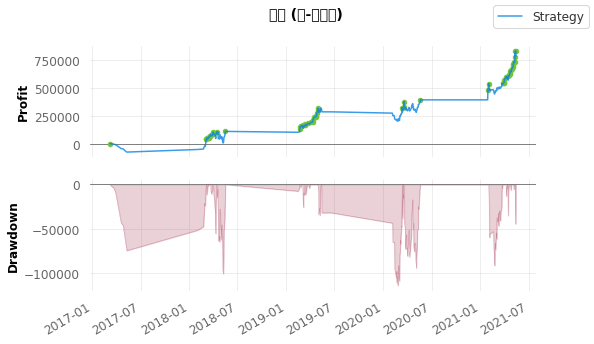

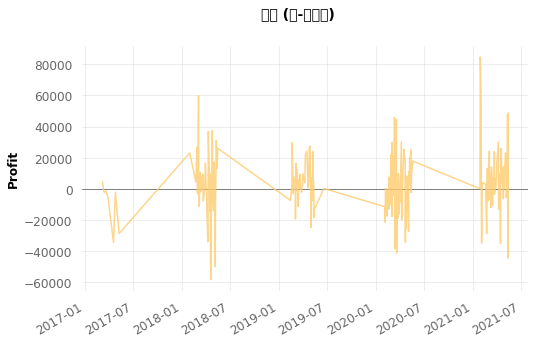

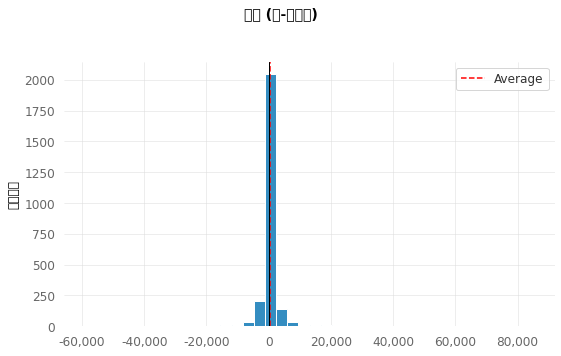

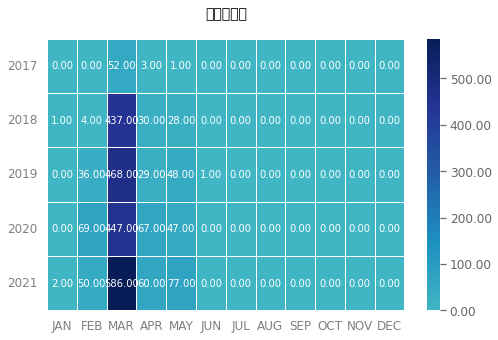

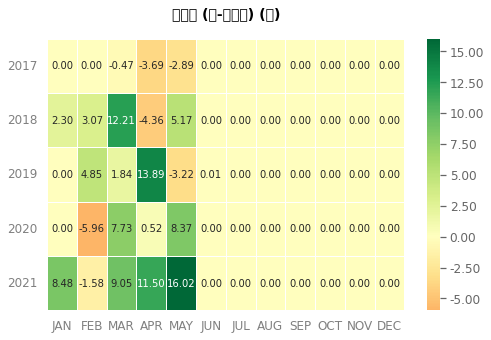

In [22]:
%reload_ext autoreload
%autoreload 2
import importlib
importlib.reload(dt)

# df_target_final = df_targetSell_copy
# df_target_final = df_target_chips

def backtest(df_target, title, types):
    df_commission = pd.DataFrame()
    discount_fee = 0.3
    slippage_fee = 0

    status = '當沖'
    # status = '隔日沖'

    if status == '當沖':
        df_target = df_target[df_target['開盤價(元)'] <= df_target['昨天收盤價(元)'] * 1.09] #開高8%或開低8%不打
        df_target = df_target[df_target['開盤價(元)'] >= df_target['昨天收盤價(元)'] * 0.91]
        
        tradeFee = 0
        inColumn = '開盤價(元)'
        outColumn = '收盤價(元)'
        stopPrice = {
            '做多停損': df_target['昨天收盤價(元)'] * 0.91,           #停損設置
            '做空停損': df_target['昨天收盤價(元)'] * 1.09,
        }
            
    elif status == '隔日沖':
        tradeFee = 0.0015
        inColumn = '收盤價(元)'
        outColumn = '明天開盤價(元)'
        stopPrice = {'做多停損': -np.inf, '做空停損': np.inf}
        
        df_target =  df_target[df_target['漲跌停'] != '+']
        
    df_commission['進場手續費'] = df_target[inColumn] * 0.001425 * discount_fee
    df_commission['進場滑價'] = df_target[inColumn] * (slippage_fee / 100)
    df_commission['出場手續費'] = df_target[outColumn] * 0.001425 * discount_fee
    df_commission['出場滑價'] = df_target[outColumn] * (slippage_fee / 100)
    df_commission['交易稅'] = df_target[outColumn] * (0.0015 + tradeFee)

    backtest = dt.Backtest(df_target, df_commission=df_commission)

    foo = backtest.run(tradeColumn={
        '進場': df_target[inColumn],
        '出場': df_target[outColumn]
    }, stopPrice=stopPrice)
    print(len(foo[foo['停損 (多-無成本)'] > 0]))
    print(len(foo[foo['停損 (空-無成本)'] > 0]))
    backtest.generateHTML(types, title=title)
    return foo
    
foo = backtest(df_target, '昨天近3月累計營收與上月比％', types=(-1, -1))